## import libararies



In [1]:
import openeo
from pathlib import Path
import config


## Generating a UDP

In [ ]:
from geospatial_pipeline.udp_generator import generate_udp, create_classification_cube
connection = openeo.connect("https://openeo.dataspace.copernicus.eu/")
connection.authenticate_oidc()

UDPdir = Path('C:/Git_projects/WAC/classification/UDP/')

generate_udp(conn=connection,
    build_pipeline_fn = create_classification_cube,  # <-- pass function, not result
    process_id =  'WAC_inference_asia',
    summary = 'WAC_inference_asia',
    output_dir = UDPdir)

Authenticated using refresh token.


NameError: name 'generate_udp' is not defined

## Main Code for creating the workflow

In [2]:
from geospatial_pipeline.input_cube_loader import load_input_cube
from geospatial_pipeline.band_normalization import normalize_cube
from geospatial_pipeline.onnx_inference import run_inference


connection = openeo.connect("https://openeo.dataspace.copernicus.eu/")
connection.authenticate_oidc()


cube = load_input_cube(
        connection,
        spatial_extent=config.SPATIAL_EXTENT,
        temporal_extent=config.TEMPORAL_EXTENT,
        max_cloud_cover=config.MAX_CLOUD_COVER,
        resolution=config.RESOLUTION,
        crs=config.CRS
    )

cube_normalised = normalize_cube(cube)

# Run inference
inference_cube = run_inference(
    cube_normalised,
    model_name=config.MODEL_NAME,
    patch_size=config.PATCH_SIZE,
    overlap=config.OVERLAP_SIZE
)

class_labels = [f"sigmoid_prob_class_{c}" for c in range(config.N_CLASSES)] + [f"classification"]
inference_cube = inference_cube.rename_labels(dimension='bands', target=class_labels)

save_inference_cube = inference_cube.save_result(format = "netCDF")
save_inference_cube


Authenticated using refresh token.


## Execute

In [3]:
job = connection.create_job(save_inference_cube,
    additional=config.JOB_OPTIONS
)
job.start_and_wait()

0:00:00 Job 'j-2508221134374a66bc7d4ccccf3c0ae4': send 'start'
0:00:12 Job 'j-2508221134374a66bc7d4ccccf3c0ae4': created (progress 0%)
0:00:18 Job 'j-2508221134374a66bc7d4ccccf3c0ae4': created (progress 0%)
0:00:24 Job 'j-2508221134374a66bc7d4ccccf3c0ae4': created (progress 0%)
0:00:32 Job 'j-2508221134374a66bc7d4ccccf3c0ae4': running (progress N/A)
0:00:42 Job 'j-2508221134374a66bc7d4ccccf3c0ae4': running (progress N/A)
0:00:55 Job 'j-2508221134374a66bc7d4ccccf3c0ae4': running (progress N/A)
0:01:10 Job 'j-2508221134374a66bc7d4ccccf3c0ae4': running (progress N/A)
0:01:29 Job 'j-2508221134374a66bc7d4ccccf3c0ae4': running (progress N/A)
0:01:53 Job 'j-2508221134374a66bc7d4ccccf3c0ae4': running (progress N/A)
0:02:23 Job 'j-2508221134374a66bc7d4ccccf3c0ae4': running (progress N/A)
0:03:01 Job 'j-2508221134374a66bc7d4ccccf3c0ae4': running (progress N/A)
0:03:48 Job 'j-2508221134374a66bc7d4ccccf3c0ae4': running (progress N/A)
0:04:46 Job 'j-2508221134374a66bc7d4ccccf3c0ae4': running (progr

<BatchJob job_id='j-2508221134374a66bc7d4ccccf3c0ae4'>

In [4]:
import xarray as xr


output_dir = "C:\\Git_projects\\WAC\\classification\\test_reference\\" + job.job_id
path = job.get_results().download_files(f"{output_dir}")
ds = xr.open_dataset(path[0])
ds


<xarray.Dataset> Size: 568MB
Dimensions:                (t: 1, x: 1618, y: 1688)
Coordinates:
  * t                      (t) datetime64[ns] 8B 2023-01-01
  * x                      (x) float64 13kB 7.162e+05 7.162e+05 ... 7.324e+05
  * y                      (y) float64 14kB 6.224e+05 6.224e+05 ... 6.055e+05
Data variables: (12/27)
    crs                    |S1 1B ...
    sigmoid_prob_class_0   (t, y, x) float64 22MB ...
    sigmoid_prob_class_1   (t, y, x) float64 22MB ...
    sigmoid_prob_class_2   (t, y, x) float64 22MB ...
    sigmoid_prob_class_3   (t, y, x) float64 22MB ...
    sigmoid_prob_class_4   (t, y, x) float64 22MB ...
    ...                     ...
    sigmoid_prob_class_20  (t, y, x) float64 22MB ...
    sigmoid_prob_class_21  (t, y, x) float64 22MB ...
    sigmoid_prob_class_22  (t, y, x) float64 22MB ...
    sigmoid_prob_class_23  (t, y, x) float64 22MB ...
    classification         (t, y, x) float64 22MB ...
    unkown_band_25         (t, y, x) float64 22MB ...
Attributes:
    Conventions:  CF-1.9
    institution:  Copernicus Data Space Ecosystem openEO API - 0.67.0a7.dev20...
    description:  
    title:

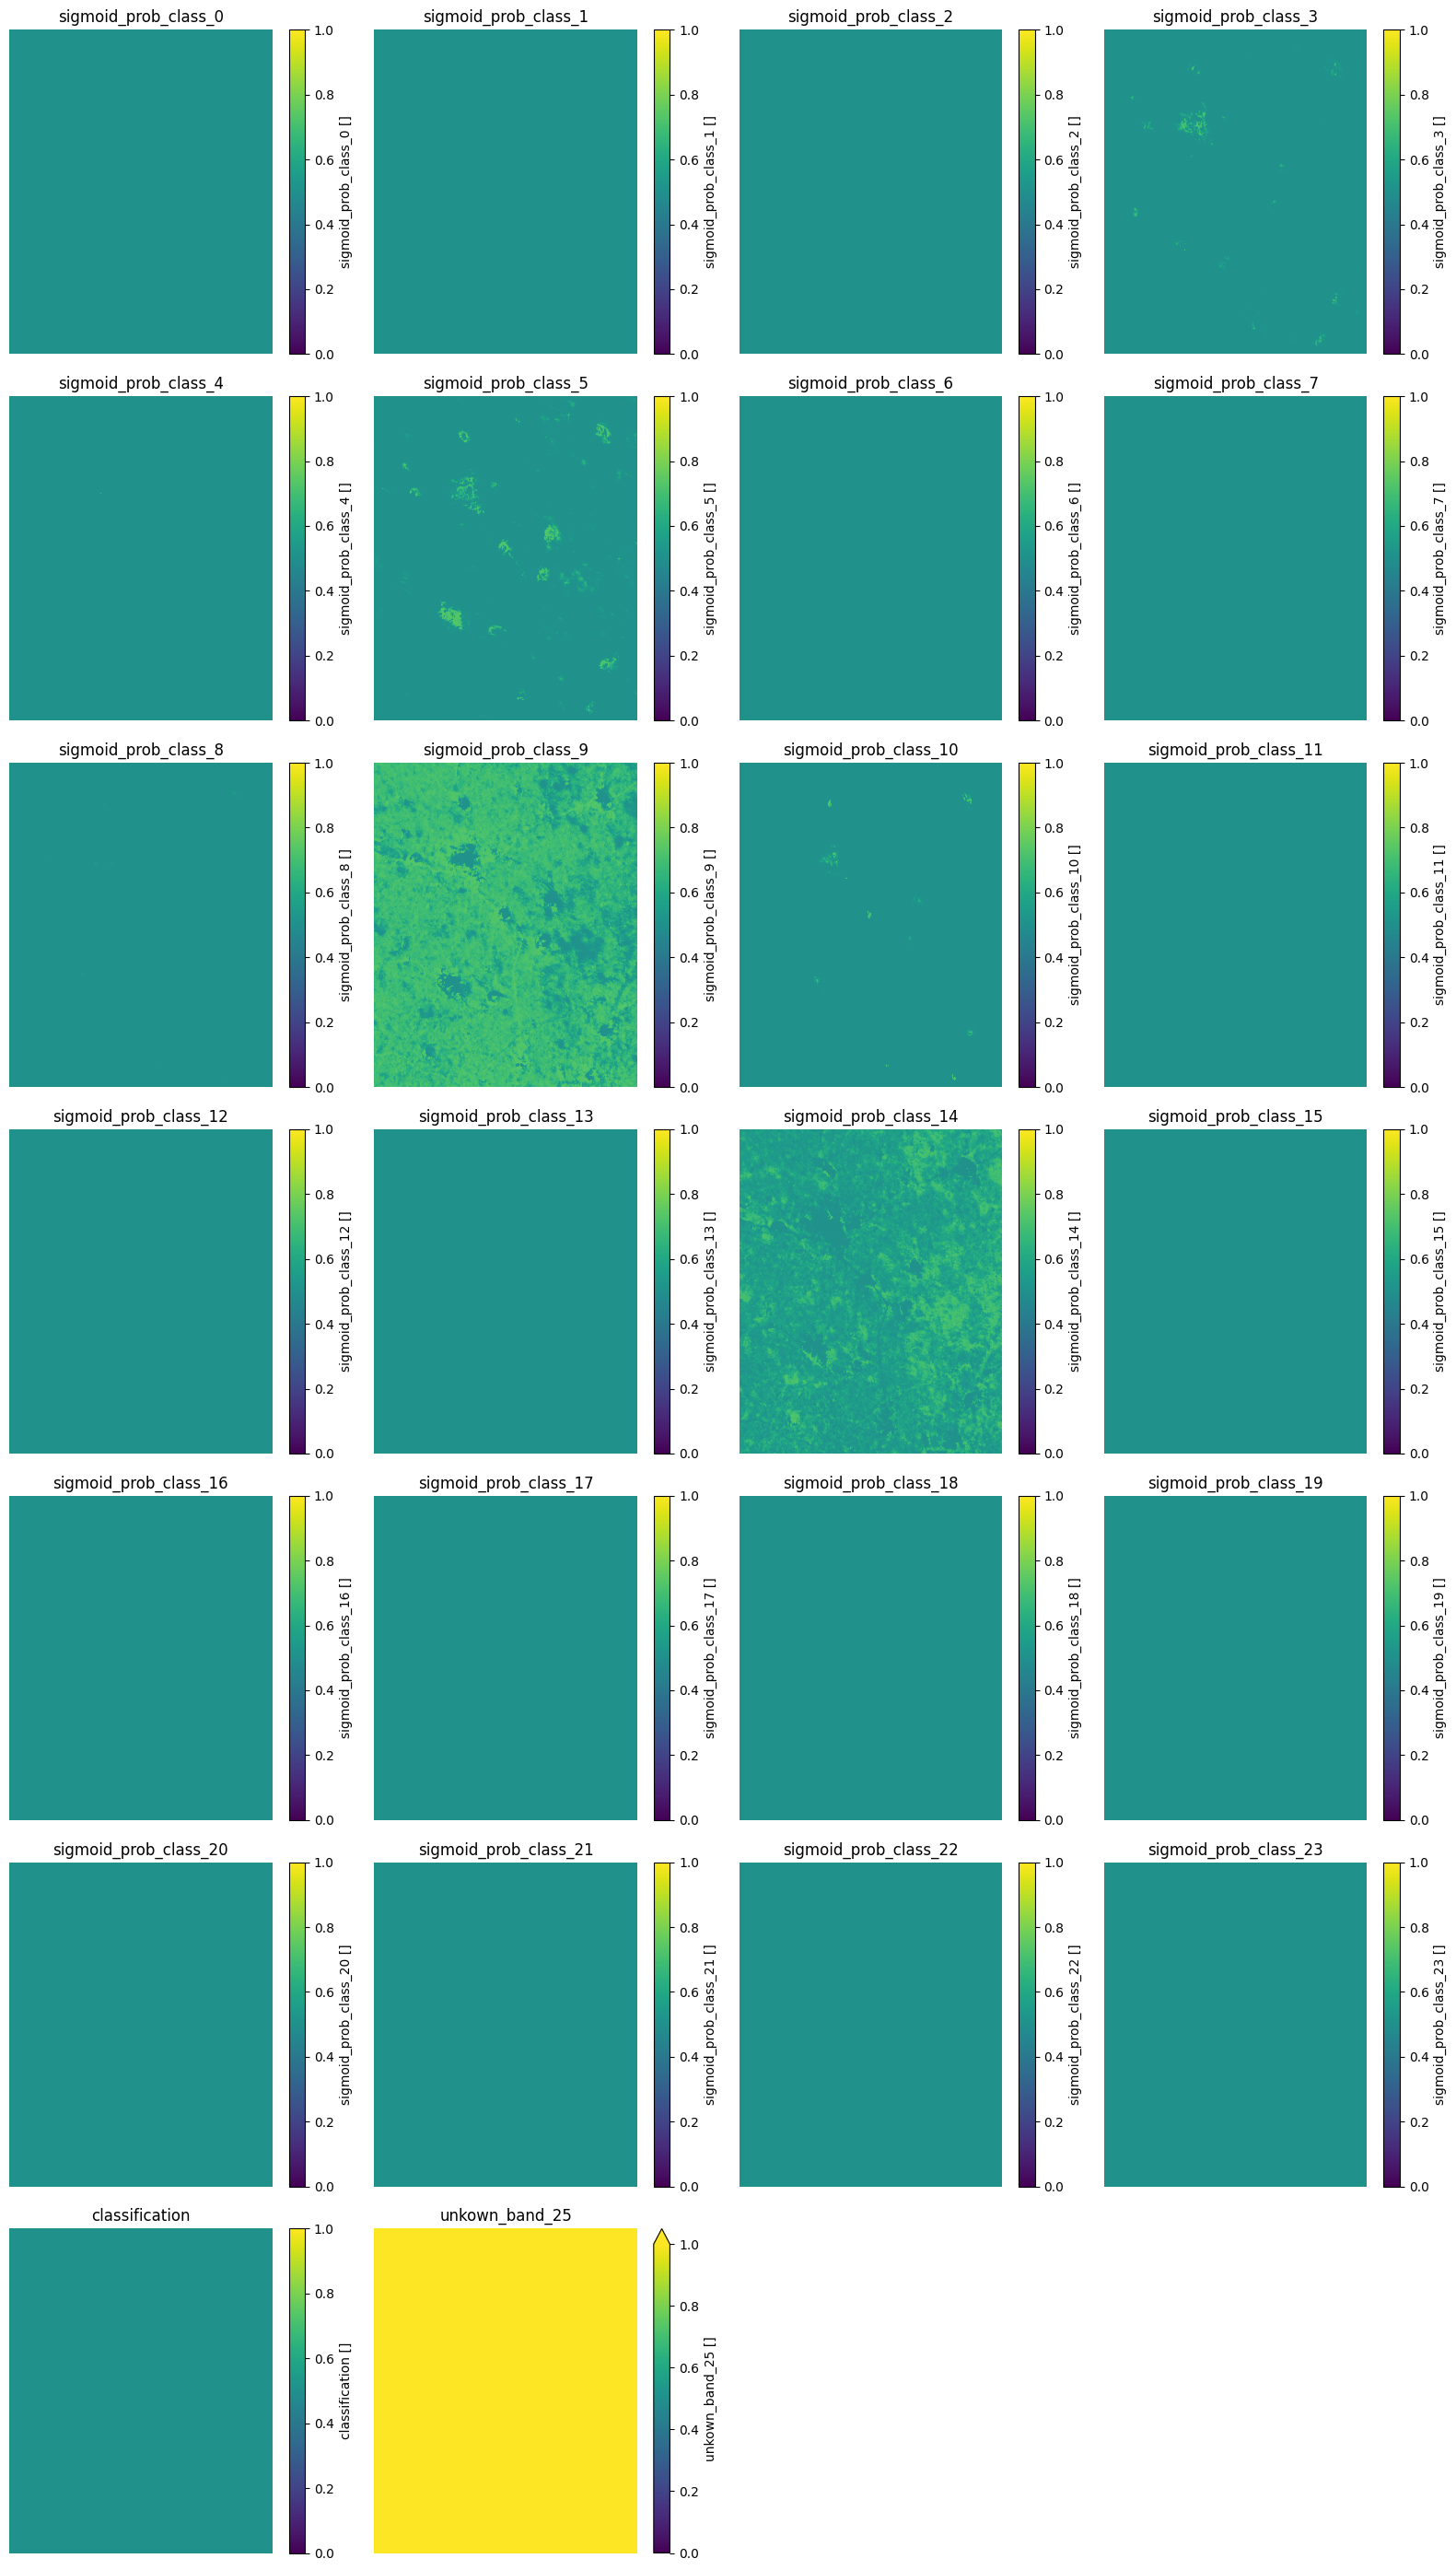

In [8]:

import matplotlib.pyplot as plt

time_step = 0
# Load dataset

# Filter only variables with dimensions (t, y, x)
variables_to_plot = [var for var in ds.data_vars if {'t', 'y', 'x'}.issubset(ds[var].dims)]

n = len(variables_to_plot)
ncols = 4  # adjust based on how wide you want the figure
nrows = -(-n // ncols)  # ceiling division

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))

# Loop through variables and plot with fixed color scale
for i, var in enumerate(variables_to_plot):
    data = ds[var].isel(t=time_step)

    ax = axes.flat[i]
    im = data.plot(ax=ax, add_colorbar=True, vmin=0, vmax=1)  # no individual colorbar
    ax.set_title(var)
    ax.axis('off')

# Hide any unused subplots
for j in range(i + 1, len(axes.flat)):
    axes.flat[j].axis('off')



plt.tight_layout()
plt.show()

